# Tutoriel : Generative Adversarial Network (GAN)


This tutoriel is based on this one : https://keras.io/examples/generative/conditional_gan/

and this one https://www.tensorflow.org/tutorials/generative/dcgan 


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import colors
%matplotlib inline

In [2]:
#%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Flatten, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, UpSampling2D, Reshape, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model

2022-05-27 23:40:13.113511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 23:40:13.113545: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## I. Dataset

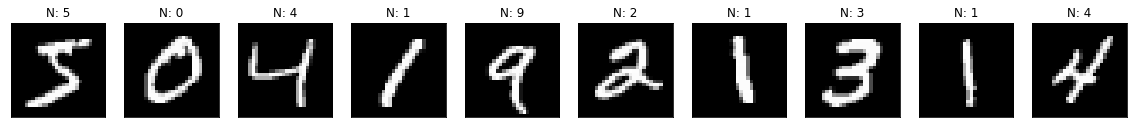

In [3]:
# Load MNIST dataset 
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizing the values (min-max normalization)
x_train = x_train / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28)) # recontruct the matrix
    plt.gray()
    plt.title("N: " + str(y_train[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## II. Discriminator

In [4]:
discriminator = keras.Sequential(
    [
        Input((28, 28, 1)),
        Conv2D(3, (3, 3), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
#         Dropout(0.3),
        Conv2D(2, (2, 2), strides=(1, 1), padding="same"),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 3)         30        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 2)         26        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 2)         0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 1)                 393       
                                                                 
Total params: 449
Trainable params: 449
Non-trainable

2022-05-27 23:40:15.598236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 23:40:15.598302: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 23:40:15.598335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kariminf-pc): /proc/driver/nvidia/version does not exist
2022-05-27 23:40:15.598944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## III. Generator

In [5]:
code_size = 10

generator = keras.Sequential(
    [
        Input((code_size,)),
        Dense(100),
        LeakyReLU(alpha=0.2),
        Reshape((5, 5, 4)),
        Conv2DTranspose(5, (4, 4), strides=(2, 2)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
#         UpSampling2D(size=(3, 3), interpolation='nearest'),
        Conv2DTranspose(5, (4, 4), strides=(2, 2)),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
#         Conv2DTranspose(2, (3, 3), strides=(1, 1)),
#         BatchNormalization(),
#         LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, (3, 3), strides=(1, 1), activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0         
                                                                 
 reshape (Reshape)           (None, 5, 5, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 5)        325       
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 5)        20        
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12, 12, 5)         0 

## IV. ConditionalGAN model

In [6]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # to save the generator's loss
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        # to save the discriminator's loss
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    # redefine the method which defines the optimizer and the loss function
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, X_real):
        # Unpack the data.

        # Sample random points in the latent space for the generator.
        M = tf.shape(X_real)[0]
        code_vectors = tf.random.normal(shape=(M, self.latent_dim))

        # Decode the noise (guided by labels) to fake images.
        X_fake = self.generator(code_vectors)

        # Combine them with real images
        X = tf.concat(
            [X_fake, X_real], axis=0
        )

        # Assemble labels discriminating real from fake images.
        # 
        Y = tf.concat(
            [tf.zeros((M, 1)), tf.ones((M, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            # apply predictions : Y_pred
            Y_pred = self.discriminator(X)
            # calculate the loss function
            d_loss = self.loss_fn(Y, Y_pred)
        # calculate the gradients over the discriminator
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply them on the discriminator's weights
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        code_vectors = tf.random.normal(shape=(M, self.latent_dim))

        # Assemble labels that say "all real images".
        Y_misleading = tf.ones((M, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            # generate some fake images using the generator
            X_fake = self.generator(code_vectors)
            # predict their labels using the discriminator
            Y_pred = self.discriminator(X_fake)
            # calculate the loss of the classification :
            # the discriminator must classify all images as real
            g_loss = self.loss_fn(Y_misleading, Y_pred)
        # calculate the gradients over the generator's weights
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Apply the gradients to the generator
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss : save it for ulterior use
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
    
gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=code_size)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

print('class created')

class created


In [7]:
gan.fit(x_train, epochs=100, batch_size=600)

2022-05-27 23:40:16.231451: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/100
100/100 [==============================] - 25s 239ms/step - g_loss: 1.4838 - d_loss: 0.4947
Epoch 2/100
100/100 [==============================] - 27s 274ms/step - g_loss: 1.4349 - d_loss: 0.4226
Epoch 3/100
100/100 [==============================] - 27s 274ms/step - g_loss: 1.0311 - d_loss: 0.6029
Epoch 4/100
100/100 [==============================] - 30s 297ms/step - g_loss: 1.0107 - d_loss: 0.7209
Epoch 5/100
100/100 [==============================] - 33s 331ms/step - g_loss: 0.7295 - d_loss: 0.7112
Epoch 6/100
100/100 [==============================] - 28s 278ms/step - g_loss: 0.8212 - d_loss: 0.6392
Epoch 7/100
100/100 [==============================] - 28s 278ms/step - g_loss: 0.7335 - d_loss: 0.6395
Epoch 8/100
100/100 [==============================] - 27s 265ms/step - g_loss: 0.8030 - d_loss: 0.6370
Epoch 9/100
100/100 [==============================] - 26s 261ms/step - g_loss: 0.8157 - d_loss: 0.6351
Epoch 10/100
100/100 [==============================] - 26s 262m

100/100 [==============================] - 27s 270ms/step - g_loss: 0.7610 - d_loss: 0.6533
Epoch 80/100
100/100 [==============================] - 27s 270ms/step - g_loss: 0.7709 - d_loss: 0.6562
Epoch 81/100
100/100 [==============================] - 27s 269ms/step - g_loss: 0.7398 - d_loss: 0.7031
Epoch 82/100
100/100 [==============================] - 27s 270ms/step - g_loss: 0.7353 - d_loss: 0.6540
Epoch 83/100
100/100 [==============================] - 27s 272ms/step - g_loss: 0.8064 - d_loss: 0.6346
Epoch 84/100
100/100 [==============================] - 27s 270ms/step - g_loss: 0.6746 - d_loss: 0.7181
Epoch 85/100
100/100 [==============================] - 27s 274ms/step - g_loss: 0.6985 - d_loss: 0.7010
Epoch 86/100
100/100 [==============================] - 27s 271ms/step - g_loss: 0.7609 - d_loss: 0.6547
Epoch 87/100
100/100 [==============================] - 27s 270ms/step - g_loss: 0.7178 - d_loss: 0.6998
Epoch 88/100
100/100 [==============================] - 27s 270ms/st

## V. Decoding fake images

1/1 [==============================] - 0s 140ms/step


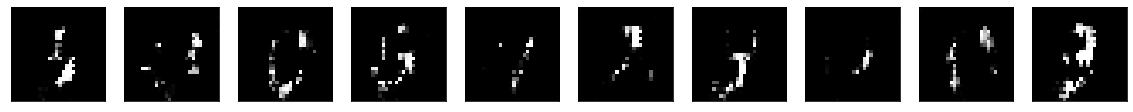

In [8]:
NBR = 10

codes = np.random.normal(size=(NBR, code_size))
decoded_imgs = generator.predict(codes)

plt.figure(figsize=(20, 4))
for i in range(NBR):
    ax = plt.subplot(1, NBR, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    #plt.title(str(codes[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()